In [81]:
%matplotlib inline

#import ROOT
#from ROOT import TCanvas, TH1F, TLegend
#from NNDefs import build_and_train_class_nn
from LayersDefs import get_signal_and_background_frames, calculate_derived_et_columns, roc_efficiencies, background_eff_at_target_signal_eff, manual_train_1d, min_manual_eff_1d
#from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from tqdm import tqdm

In [82]:
signal_frame, background_frame = get_signal_and_background_frames()

all_frame = pd.concat([signal_frame, background_frame], sort=True)

In [83]:
calculate_derived_et_columns(signal_frame, background_frame)

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1, 1, 1], column_names=['L0Et', 'L1Et', 'L2Et', 'L3Et'],
                                     output_column_name='EMEt')

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L0Et', 'L1Et'],
                             output_column_name='L0+L1Et')

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L2Et', 'L3Et'],
                             output_column_name='L2+L3Et')

# Calculate 3 layer with minimum weights
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1.3, 8.4], column_names=['L0+L1Et', 'L2+L3Et', 'HadEt'],
                             output_column_name='3LayerWeightedEt')

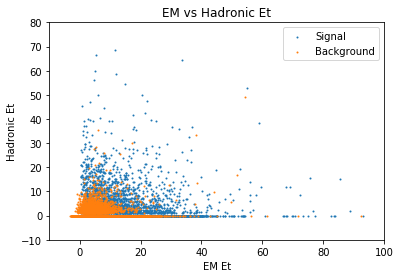

In [52]:
plt.scatter(signal_frame[['EMEt']].values, signal_frame[['HadEt']].values, 1, label='Signal')
plt.scatter(background_frame[['EMEt']].values, background_frame[['HadEt']].values, 1, label='Background')
#plt.plot([-10,46], [14.3, -10], color='k')
plt.title('EM vs Hadronic Et')
plt.xlabel('EM Et')
plt.xlim(-10, 100)
plt.ylabel('Hadronic Et')
plt.ylim(-10, 80)
plt.legend(loc='upper right')
plt.show()

In [4]:
signal_em_values = signal_frame['EMEt'].values
signal_had_values = signal_frame['HadEt'].values

background_em_values = background_frame['EMEt'].values
background_had_values = background_frame['HadEt'].values

sig_hist, sig_xedges, sig_yedges = np.histogram2d(signal_em_values, signal_had_values, bins=20, range=[[0, 20], [0, 20]], density=True)
back_hist, back_xedges, back_yedges = np.histogram2d(background_em_values, background_had_values, bins=20, range=[[0, 20], [0, 20]], density=True)

x_pos, y_pos = np.meshgrid(sig_xedges[:-1], sig_yedges[:-1])
x_pos = x_pos.ravel()
y_pos = y_pos.ravel()
z_pos = 0

dx = dy = 0.5
sig_dz = sig_hist.ravel()
back_dz = back_hist.ravel()

print(len(x_pos))
#print(len(dz))

400


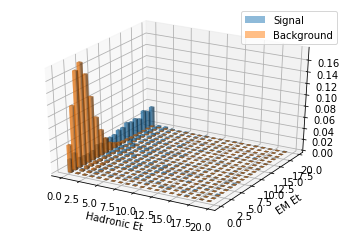

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x_pos, y_pos, z_pos, dx, dy, sig_dz, alpha=0.5, label='Signal')
ax.bar3d(x_pos, y_pos, z_pos, dx, dy, back_dz, alpha=0.5, label='Background')

ax.set_xlabel('Hadronic Et')
ax.set_ylabel('EM Et')

sig_proxy = plt.Rectangle((0, 0), 1, 1, fc='C0', alpha=0.5)
back_proxy = plt.Rectangle((0, 0), 1, 1, fc='C1', alpha=0.5)
ax.legend([sig_proxy, back_proxy], ['Signal', 'Background'])

plt.show()

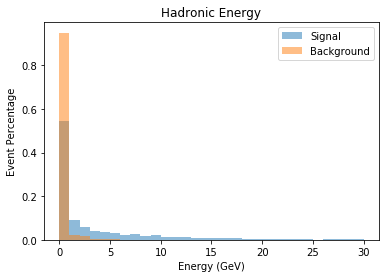

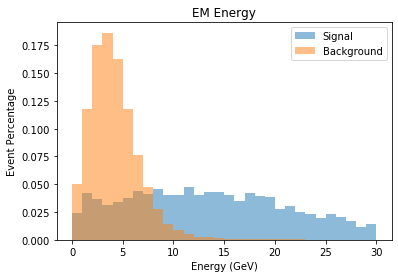

In [7]:
range_val = 30

plt.hist(signal_had_values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Signal')
plt.hist(background_had_values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Background')
plt.title('Hadronic Energy')
plt.xlabel('Energy (GeV)')
plt.ylabel('Event Percentage')
plt.legend(loc='upper right')
plt.show()

plt.hist(signal_em_values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Signal')
plt.hist(background_em_values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Background')
plt.title('EM Energy')
plt.xlabel('Energy (GeV)')
plt.ylabel('Event Percentage')
plt.legend(loc='upper right')
plt.show()

In [69]:
zero_had_signal_criteria = signal_frame['HadEt'] == 0
zero_had_background_criteria = background_frame['HadEt'] == 0

nonzero_had_signal_criteria = [not i for i in zero_had_signal_criteria]
nonzero_had_background_criteria = [not i for i in zero_had_background_criteria]

zero_had_signal = signal_frame.loc[zero_had_signal_criteria].copy()
zero_had_background = background_frame.loc[zero_had_background_criteria].copy()

nonzero_had_signal = signal_frame.loc[nonzero_had_signal_criteria].copy()
nonzero_had_background = background_frame.loc[nonzero_had_background_criteria].copy()

In [78]:
print('Percentage of events with 0 hadronic energy:')
print('Signal: ',len(zero_had_signal))
print('Background: ',len(zero_had_background))

print('Percentage of events with non-0 hadronic energy:')
print('Signal: ',len(nonzero_had_signal))
print('Background: ',len(nonzero_had_background))

Percentage of events with 0 hadronic energy:
Signal:  2181
Background:  65551
Percentage of events with non-0 hadronic energy:
Signal:  1897
Background:  3498


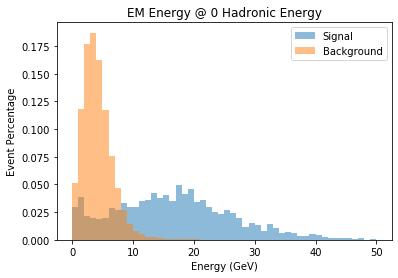

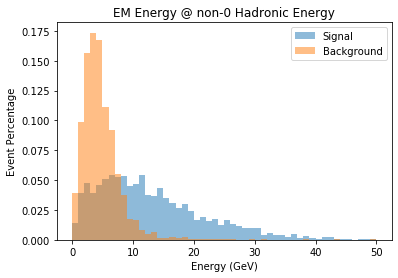

In [73]:
range_val = 50

plt.hist(zero_had_signal['EMEt'].values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Signal')
plt.hist(zero_had_background['EMEt'].values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Background')
plt.title('EM Energy @ 0 Hadronic Energy')
plt.xlabel('Energy (GeV)')
plt.ylabel('Event Percentage')
plt.legend(loc='upper right')
plt.show()

plt.hist(nonzero_had_signal['EMEt'].values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Signal')
plt.hist(nonzero_had_background['EMEt'].values, range_val, alpha=0.5, density=True, range=[0, range_val], label='Background')
plt.title('EM Energy @ non-0 Hadronic Energy')
plt.xlabel('Energy (GeV)')
plt.ylabel('Event Percentage')
plt.legend(loc='upper right')
plt.show()

In [103]:
had_cutoff = 0
#em_cutoff = 4

energies = 41

signal_efficiencies = np.zeros(energies)
background_efficiencies = np.zeros(energies)

weighted_signal_efficiencies = np.zeros(energies)
weighted_background_efficiencies = np.zeros(energies)

for i in range(energies):
    em_cutoff = i * 0.5
    
    signal_criteria = (signal_frame['EMEt'] > em_cutoff) | (signal_frame['HadEt'] > had_cutoff)
    background_criteria = (background_frame['EMEt'] > em_cutoff) | (background_frame['HadEt'] > had_cutoff)
    
    weighted_signal_criteria = (signal_frame['3LayerWeightedEt'] > em_cutoff) | (signal_frame['HadEt'] > had_cutoff)
    weighted_background_criteria = (background_frame['3LayerWeightedEt'] > em_cutoff) | (background_frame['HadEt'] > had_cutoff)
    
    signal_frame_cut = signal_frame[signal_criteria]
    background_frame_cut = background_frame[background_criteria]
    
    weighted_signal_frame_cut = signal_frame[weighted_signal_criteria]
    weighted_background_frame_cut = background_frame[weighted_background_criteria]
    
    signal_efficiencies[i] = len(signal_frame_cut) / len(signal_frame)
    background_efficiencies[i] = len(background_frame_cut) / len(background_frame) 
    
    weighted_signal_efficiencies[i] = len(weighted_signal_frame_cut) / len(signal_frame)
    weighted_background_efficiencies[i] = len(weighted_background_frame_cut) / len(background_frame) 

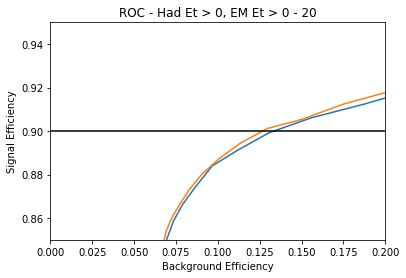

In [102]:
plt.plot(background_efficiencies, signal_efficiencies)
plt.plot(weighted_background_efficiencies, weighted_signal_efficiencies)
plt.plot([0, 1], [0.9, 0.9], color='k')
plt.title('ROC - Had Et > 0, EM Et > 0 - 20')
plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.xlim([0, 0.2])
plt.ylim([0.85, 0.95])
plt.show()

In [106]:
#for i, j in zip(weighted_signal_efficiencies, weighted_background_efficiencies):
#    print(i, j)

print(weighted_signal_efficiencies)

[1.         0.9973026  0.98970083 0.97694949 0.96812163 0.96174595
 0.95684159 0.95316332 0.94850417 0.94335459 0.94065718 0.9355076
 0.93207455 0.92913193 0.92545365 0.91883276 0.91245709 0.90534576
 0.90117705 0.89431094 0.88695439 0.87984306 0.87297695 0.86635606
 0.86071604 0.85434036 0.84526729 0.8386464  0.83153507 0.82515939
 0.81804806 0.81020108 0.79916626 0.78739578 0.78003923 0.7714566
 0.7621383  0.7540461  0.74448259 0.73761648 0.72952428]


In [32]:
em_cut = -10
had_cut = 1

signal_criteria = (signal_frame['EMEt'] > em_cut) | (signal_frame['HadEt'] > had_cut)
background_criteria = (background_frame['EMEt'] > em_cut) | (background_frame['HadEt'] > had_cut)

signal_frame_cut = signal_frame.loc[signal_criteria].copy()
background_frame_cut = background_frame.loc[background_criteria].copy()

print(len(signal_frame_cut) / len(signal_frame))
print(len(background_frame_cut) / len(background_frame))

# Overall signal efficiency whose background efficiency we are working to minimize
target_eff = 0.9
# Signal efficiency after cutting on EM Et and Had Et, cutting out a square in Et space hence box
box_cut_eff = len(signal_frame_cut) / len(signal_frame)
# Signal efficiency we must tune with ROC curve to achieve target efficiency given box cut
roc_eff = target_eff / box_cut_eff 

In [38]:
print(roc_eff)

0.9


In [46]:
weights = [0.1 * i for i in range(101)]
           
efficiencies = manual_train_1d(signal_frame, background_frame, ['EMEt', 'HadEt'], weights, .9)

min_eff, min_weight = min_manual_eff_1d(efficiencies, weights)

print(min_eff)
print(min_weight)

0.133513881446509
5.9


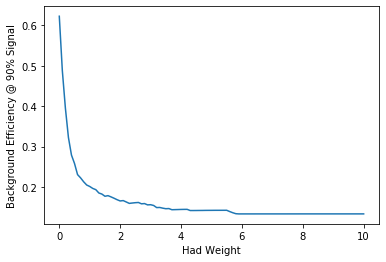

In [53]:
plt.plot(weights, efficiencies)
plt.xlabel('Had Weight')
plt.ylabel('Background Efficiency @ 90% Signal')
plt.show()

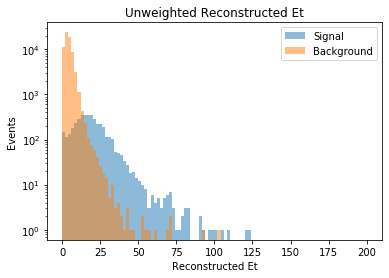

In [46]:
plt.hist(signal_frame['TotalEt'], 100, (0,200), log=True, alpha=0.5, label='Signal')
plt.hist(background_frame['TotalEt'], 100, (0, 200), alpha=0.5, label='Background')
plt.title('Unweighted Reconstructed Et')
plt.xlabel('Reconstructed Et')
plt.ylabel('Events')
plt.legend(loc='upper right')
plt.show()

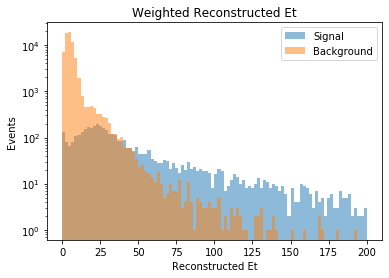

In [45]:
plt.hist(signal_frame['3LayerWeightedEt'], 100, (0,200), log=True, alpha=0.5, label='Signal')
plt.hist(background_frame['3LayerWeightedEt'], 100, (0, 200), alpha=0.5, label='Background')
plt.title('Weighted Reconstructed Et')
plt.xlabel('Reconstructed Et')
plt.ylabel('Events')
plt.legend(loc='upper right')
plt.show()

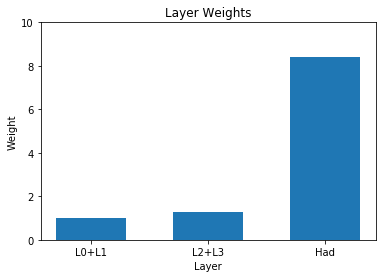

In [9]:
weights = [1, 1.3, 8.4]
ticks = [.5, 1, 1.5]
plt.bar(ticks, weights, 0.3)
plt.xticks(ticks, ('L0+L1', 'L2+L3', 'Had'))
plt.title('Layer Weights')
plt.xlabel('Layer')
plt.ylabel('Weight')
plt.ylim(0,10)
plt.show()